## Binary Classificaiton

### Feature Selection

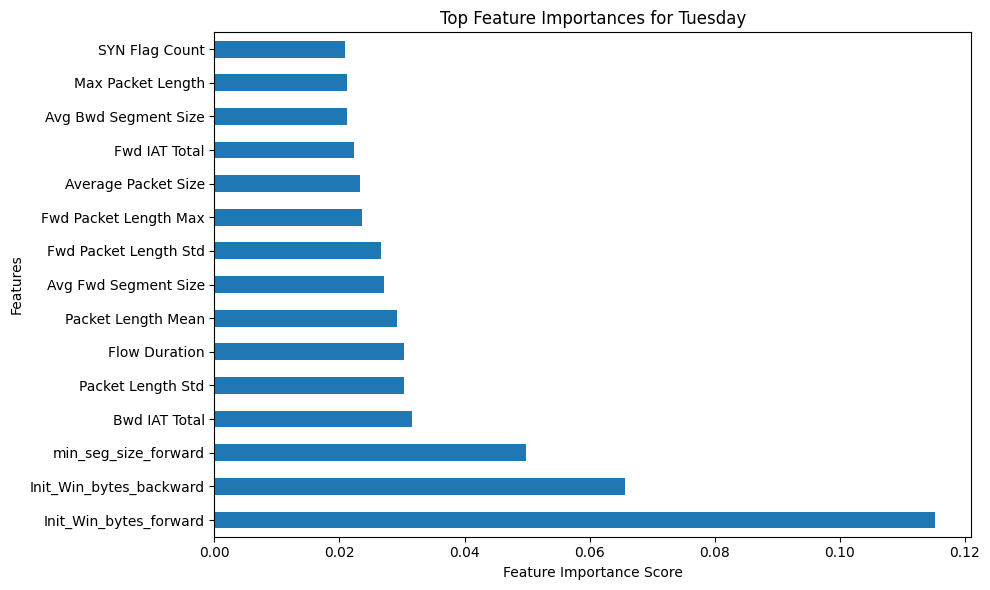

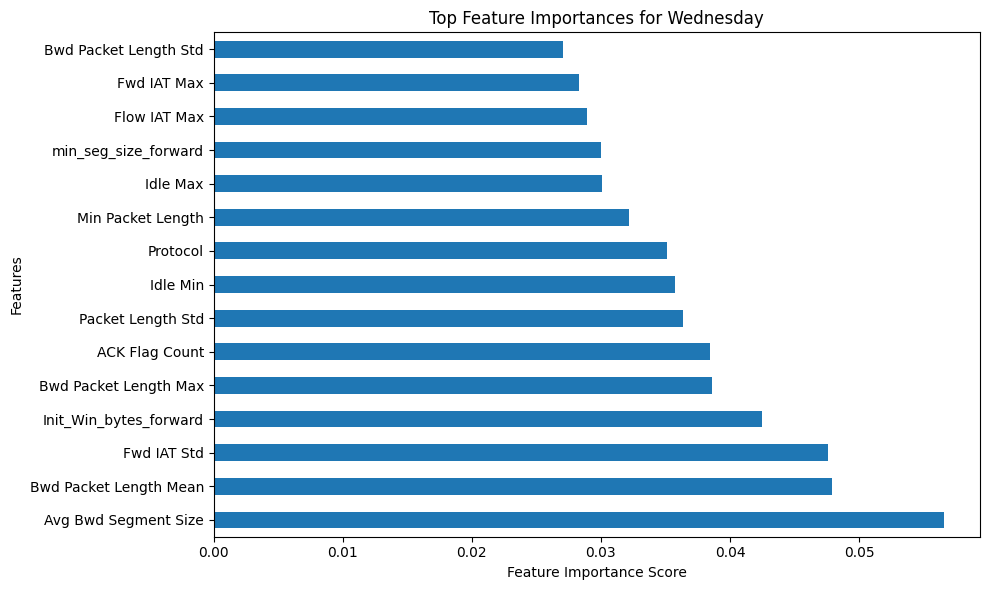

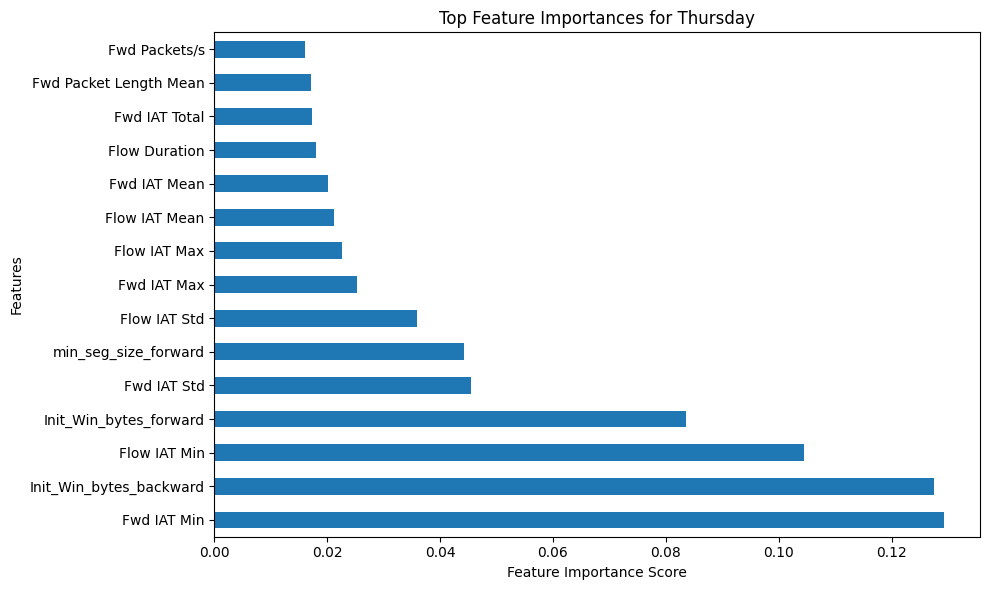

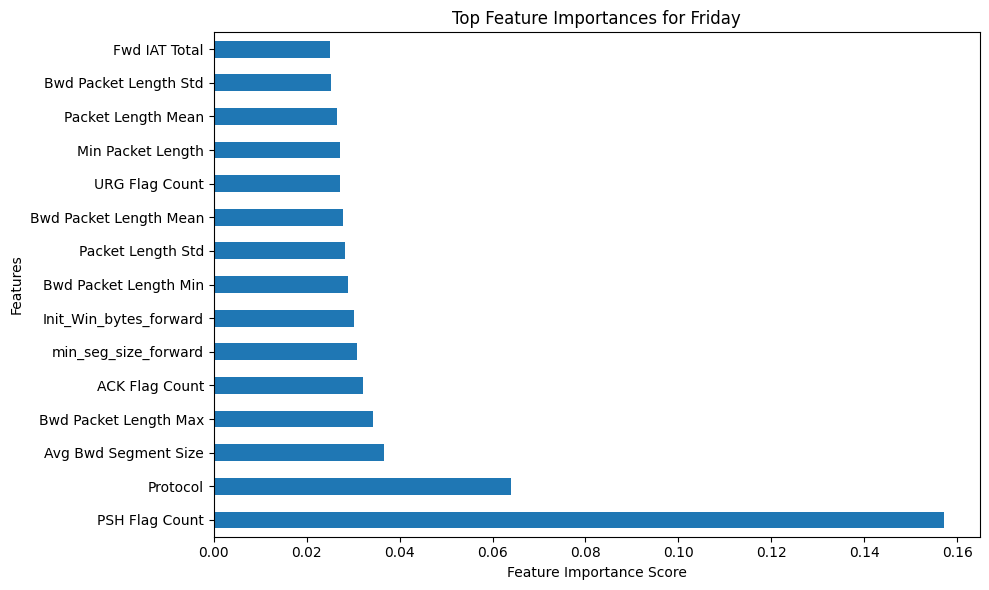

Top features for Tuesday:
['Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Bwd IAT Total', 'Packet Length Std', 'Flow Duration', 'Packet Length Mean', 'Avg Fwd Segment Size', 'Fwd Packet Length Std', 'Fwd Packet Length Max', 'Average Packet Size', 'Fwd IAT Total', 'Avg Bwd Segment Size', 'Max Packet Length', 'SYN Flag Count']

Top features for Wednesday:
['Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Fwd IAT Std', 'Init_Win_bytes_forward', 'Bwd Packet Length Max', 'ACK Flag Count', 'Packet Length Std', 'Idle Min', 'Protocol', 'Min Packet Length', 'Idle Max', 'min_seg_size_forward', 'Flow IAT Max', 'Fwd IAT Max', 'Bwd Packet Length Std']

Top features for Thursday:
['Fwd IAT Min', 'Init_Win_bytes_backward', 'Flow IAT Min', 'Init_Win_bytes_forward', 'Fwd IAT Std', 'min_seg_size_forward', 'Flow IAT Std', 'Fwd IAT Max', 'Flow IAT Max', 'Flow IAT Mean', 'Fwd IAT Mean', 'Flow Duration', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Fwd Packets/s']

Top featur

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

PATH = "datasets"

# GLOBAL VARIABLES
TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Define the path to the CSV files and the output directory
output_path = PATH + '/feat_sel/binary-class'

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to preprocess data and return top features
def process_data(day):
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)
    
    # ... [Data preprocessing steps] ...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data.rename(columns={'Label': 'label'}, inplace=True)
    data['binary_label'] = data['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    
    # print(data.columns)
    
    drop_columns = [
        "Flow ID", "Source IP", "Source Port", "Destination IP", 
        "Destination Port",
        "Timestamp", 
        "Fwd Header Length.1", 
        "label"
    ]
    data.drop(columns=drop_columns, inplace=True)
    
    X = data.drop('binary_label', axis=1)
    y = data['binary_label']

    # Build the model
    model = ExtraTreesClassifier()
    model.fit(X, y)
    
    # Get feature importances
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    # Select top N features
    top_features = feat_importances.nlargest(15).index.tolist()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title(f'Top Feature Importances for {day}')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{day}_feature_importances.png"))  # Save the figure
    # plt.close()  # Close the plot to prevent it from displaying inline if using a notebook
    plt.show()
    
    return top_features

# Dictionary to store top features for each day
top_features_per_day = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    top_features_per_day[day] = process_data(day)

# Print out the top features for each day
for day, features in top_features_per_day.items():
    print(f"Top features for {day}:\n{features}\n")

json_file_path = os.path.join(output_path, 'top_features_per_day.json')
with open(json_file_path, 'w') as json_file:
    json.dump(top_features_per_day, json_file, indent=4)

print(f"Top features for each day have been saved to {json_file_path}")

### Classification

In [4]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Initialize a dictionary to store the metrics for each model
model_metrics = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)
    
    # Preprocessing steps identical to the feature selection stage...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data['binary_label'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    X = data[top_features_per_day[day]]
    y = data['binary_label']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize classifiers
    classifiers = {
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB()
    }
    
    # Train and evaluate each classifier
    for model_name, model in classifiers.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute the metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        # Store metrics
        if day not in model_metrics:
            model_metrics[day] = {}
        model_metrics[day][model_name] = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        }

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict({(i, j): model_metrics[i][j]
                                     for i in model_metrics.keys()
                                     for j in model_metrics[i].keys()},
                                    orient='index')

# Display the DataFrame
print(metrics_df)

# Specify the path for the JSON file where the metrics will be stored
metrics_json_path = os.path.join(output_path, 'model_performance_metrics.json')

# Convert the DataFrame into a JSON string and save it to a file
metrics_df.to_json(metrics_json_path, orient='split', indent=4)

# print(f"Model performance metrics have been saved to {metrics_json_path}")

                        Precision    Recall  Accuracy  F1 Score   ROC AUC
Tuesday   DecisionTree   0.996870  0.997590  0.999828  0.997230  0.998745
          RandomForest   1.000000  0.997108  0.999910  0.998552  0.998554
          NaiveBayes     0.045296  0.998554  0.346642  0.086660  0.662156
Wednesday DecisionTree   0.998109  0.999404  0.999094  0.998756  0.999160
          RandomForest   0.996436  0.999603  0.998554  0.998017  0.998778
          NaiveBayes     0.776975  0.674828  0.811090  0.722308  0.781965
Thursday  DecisionTree   0.971471  0.972932  0.999731  0.972201  0.986397
          RandomForest   0.996845  0.950376  0.999746  0.973056  0.975181
          NaiveBayes     0.019946  0.917293  0.781761  0.039044  0.849198
Friday    DecisionTree   0.996368  0.997565  0.997505  0.996966  0.997514
          RandomForest   0.996517  0.997461  0.997524  0.996989  0.997514
          NaiveBayes     0.684257  0.836350  0.774149  0.752697  0.783552


## Multi-class Classification

### Feature Selection

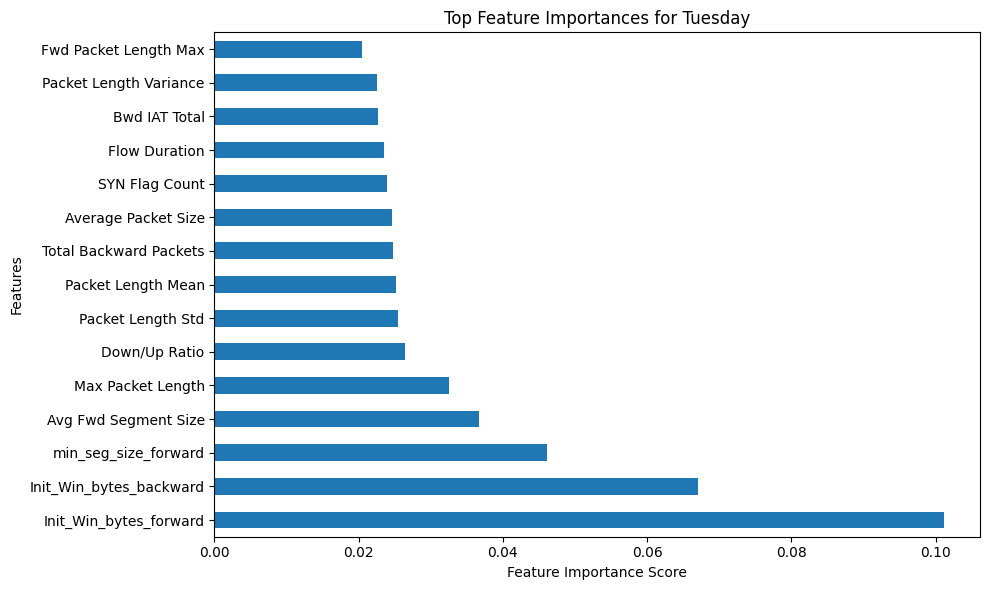

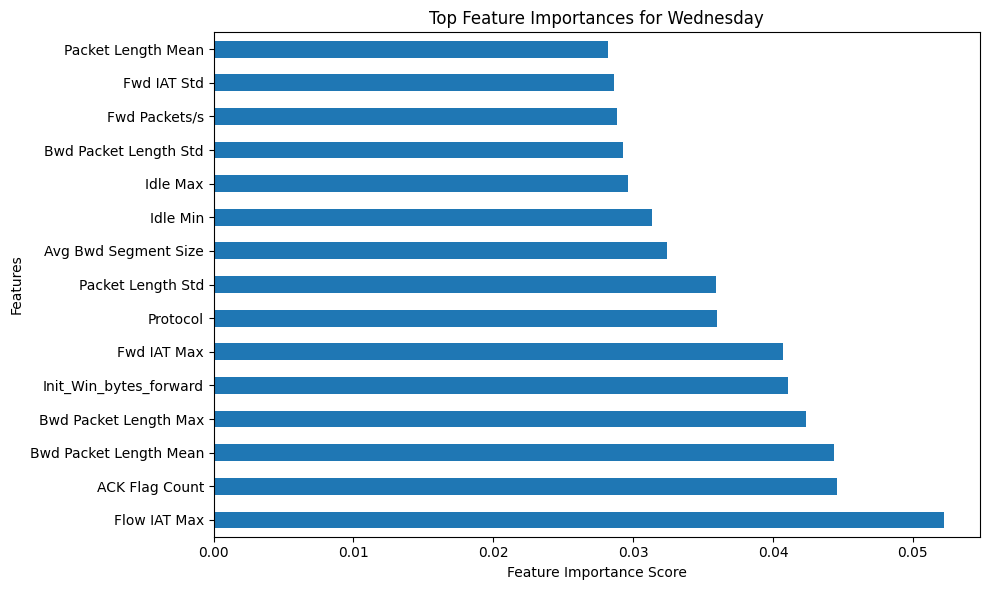

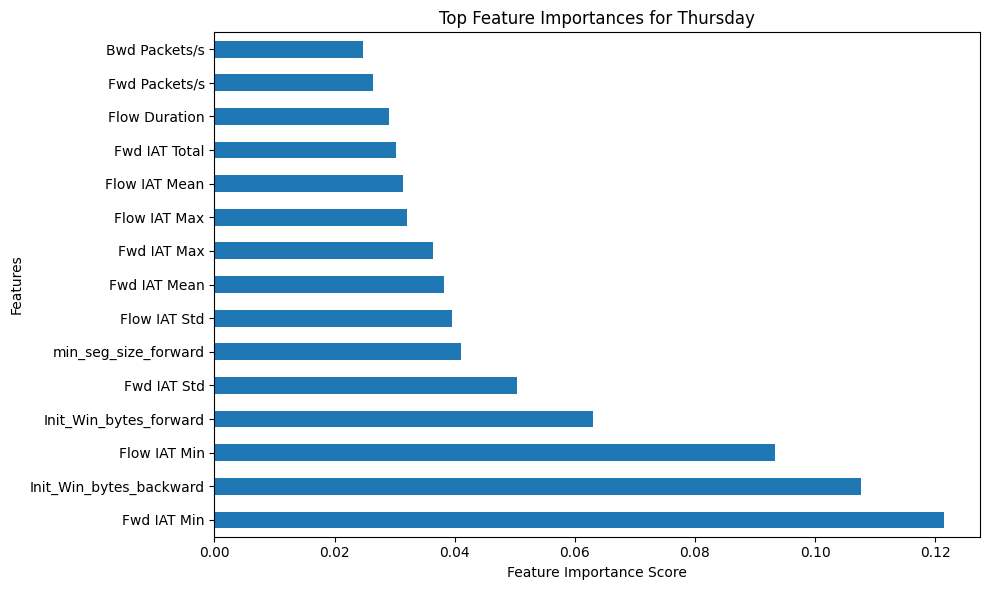

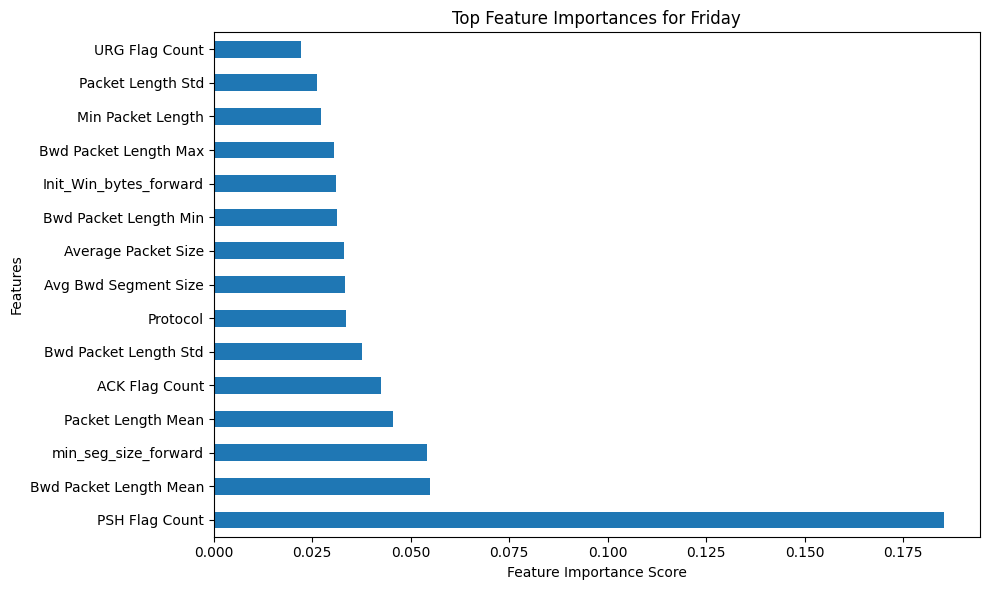

Top features for Tuesday:
['Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Avg Fwd Segment Size', 'Max Packet Length', 'Down/Up Ratio', 'Packet Length Std', 'Packet Length Mean', 'Total Backward Packets', 'Average Packet Size', 'SYN Flag Count', 'Flow Duration', 'Bwd IAT Total', 'Packet Length Variance', 'Fwd Packet Length Max']

Top features for Wednesday:
['Flow IAT Max', 'ACK Flag Count', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Init_Win_bytes_forward', 'Fwd IAT Max', 'Protocol', 'Packet Length Std', 'Avg Bwd Segment Size', 'Idle Min', 'Idle Max', 'Bwd Packet Length Std', 'Fwd Packets/s', 'Fwd IAT Std', 'Packet Length Mean']

Top features for Thursday:
['Fwd IAT Min', 'Init_Win_bytes_backward', 'Flow IAT Min', 'Init_Win_bytes_forward', 'Fwd IAT Std', 'min_seg_size_forward', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Max', 'Flow IAT Max', 'Flow IAT Mean', 'Fwd IAT Total', 'Flow Duration', 'Fwd Packets/s', 'Bwd Packets/s']

Top features for Frida

In [5]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import json

# GLOBAL VARIABLES
TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Define the path to the CSV files and the output directory for multi-class classification
output_path = PATH + '/feat_sel/multi-class'

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to preprocess data and return top features
def process_data(day):
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)
    
    # ... [Data preprocessing steps] ...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data.rename(columns={'Label': 'label'}, inplace=True)
    
    # For multi-class classification, use the 'label' column directly
    # No need for a binary label
    drop_columns = [
        "Flow ID", "Source IP", "Source Port", "Destination IP", 
        "Destination Port",
        "Timestamp", 
        "Fwd Header Length.1"
    ]
    data.drop(columns=drop_columns, inplace=True)
    
    X = data.drop('label', axis=1)
    y = data['label']  # This will now have multiple classes

    # Build the model
    model = ExtraTreesClassifier()
    model.fit(X, y)
    
    # Get feature importances
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    # Select top N features
    top_features = feat_importances.nlargest(15).index.tolist()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title(f'Top Feature Importances for {day}')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{day}_feature_importances.png"))  # Save the figure
    plt.show()
    
    return top_features

# Dictionary to store top features for each day
top_features_per_day = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    top_features_per_day[day] = process_data(day)

# Print out the top features for each day
for day, features in top_features_per_day.items():
    print(f"Top features for {day}:\n{features}\n")

# Save the top features for each day into a JSON file
json_file_path = os.path.join(output_path, 'top_features_per_day_multi_class.json')
with open(json_file_path, 'w') as json_file:
    json.dump(top_features_per_day, json_file, indent=4)

print(f"Top features for each day have been saved to {json_file_path}")

### Classificaiton

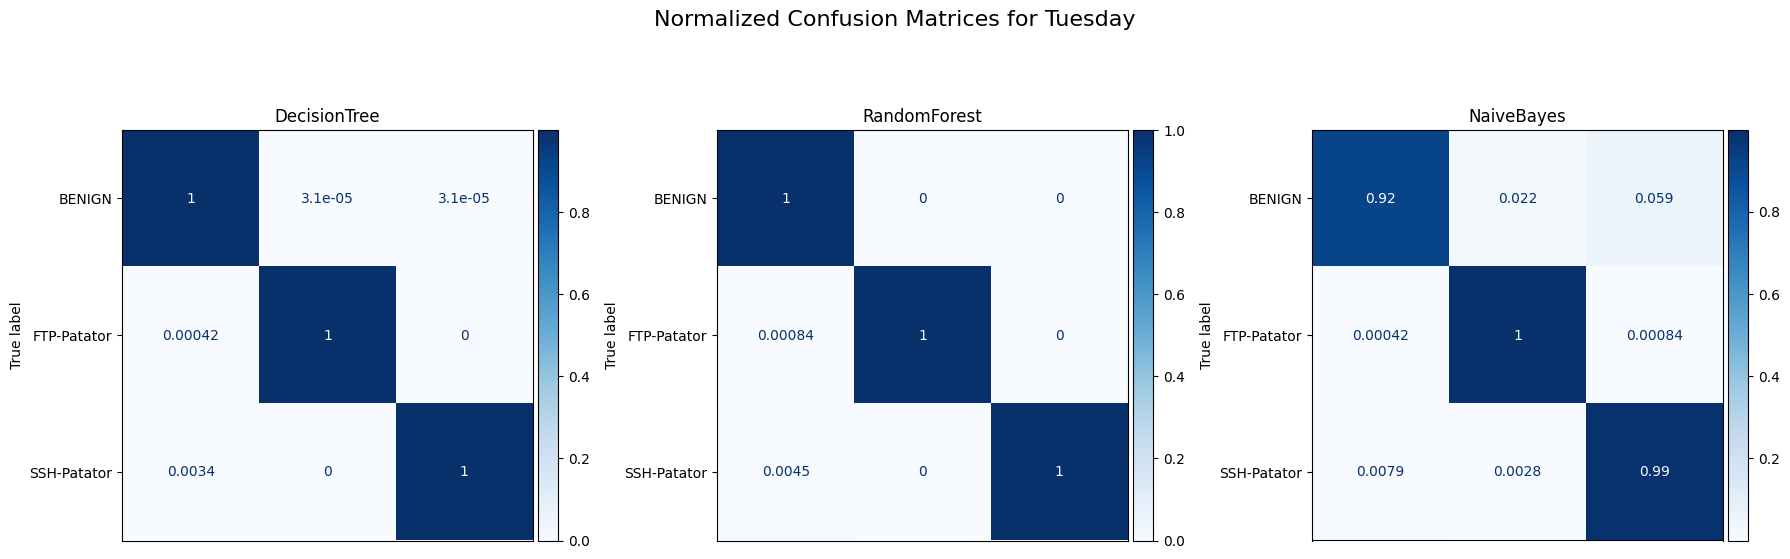

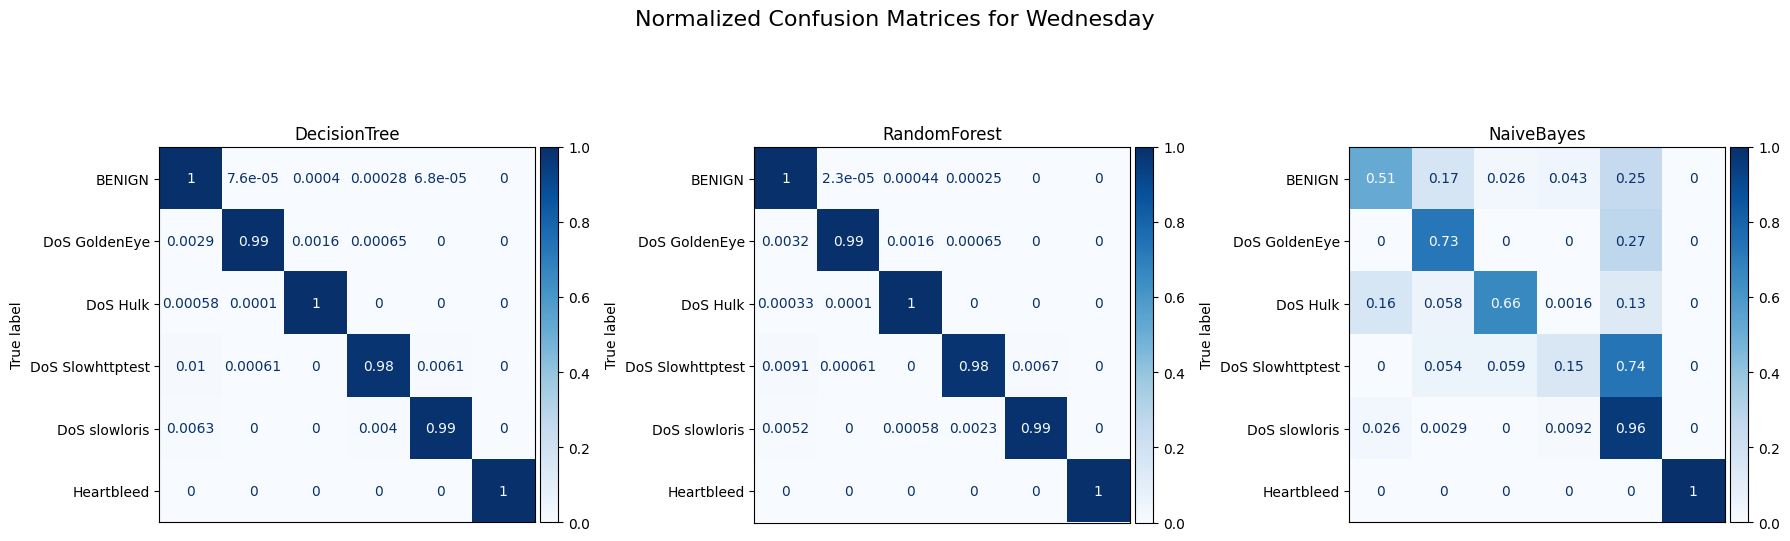

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7fcee9c4be20>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 61, in _cb
    callback(self)
  File "/home/vke/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 254, in _remove_proxy
    del self.callbacks[signal][cid]
KeyError: 'changed'


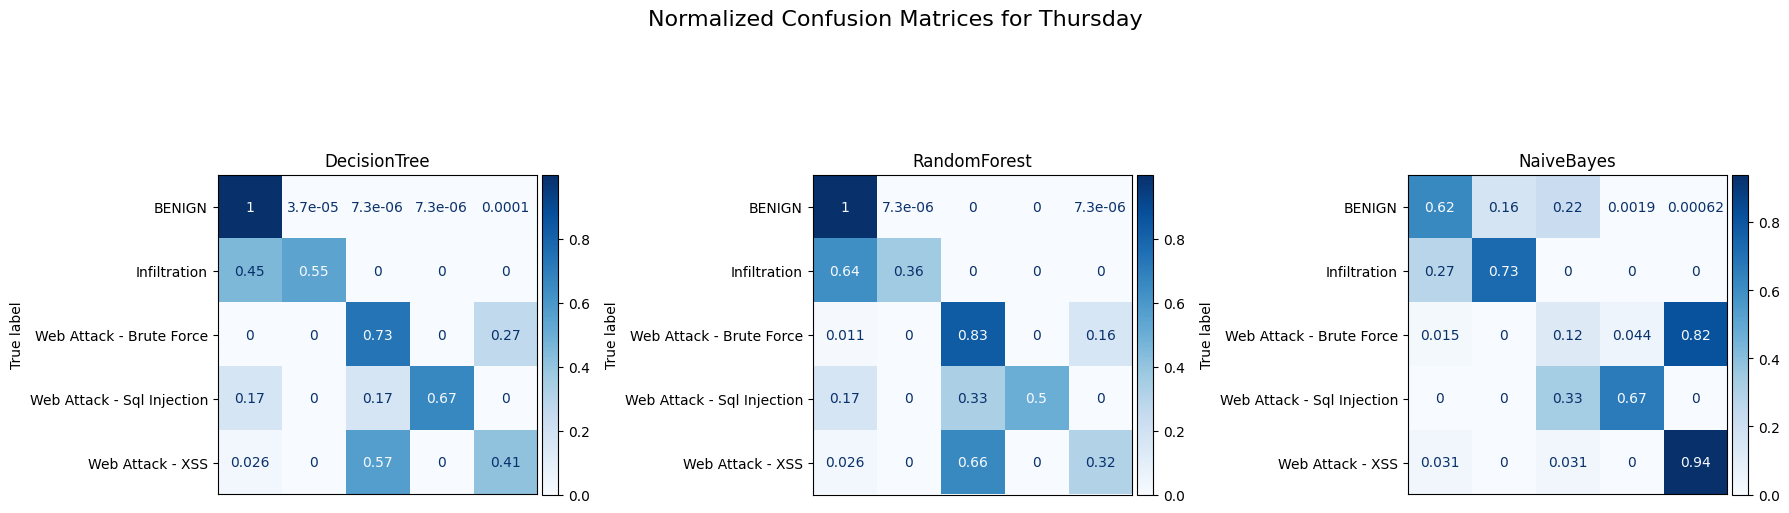

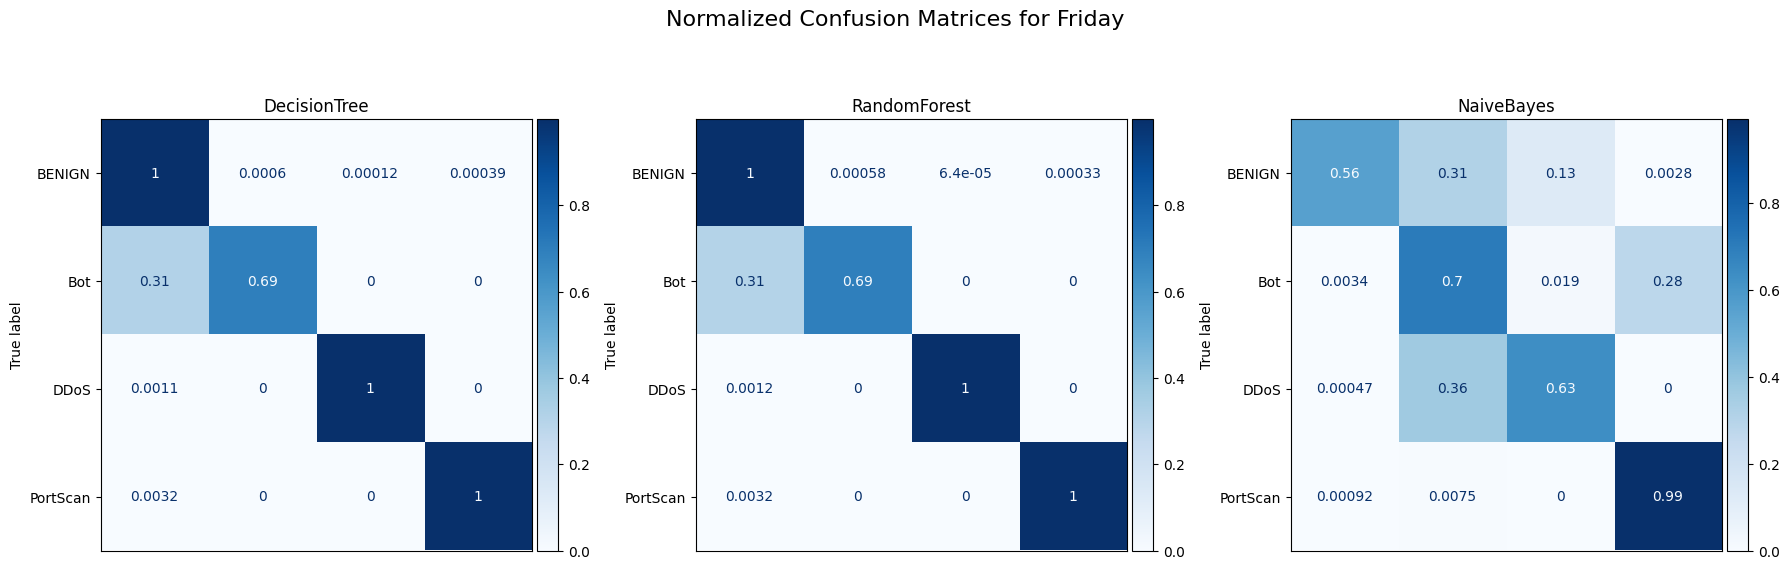

                        Precision    Recall  Accuracy  F1 Score   ROC AUC
Tuesday   DecisionTree   0.999888  0.999888  0.999888  0.999888  0.999247
          RandomForest   0.999925  0.999925  0.999925  0.999925  1.000000
          NaiveBayes     0.979395  0.921044  0.921044  0.943105  0.990472
Wednesday DecisionTree   0.998951  0.998949  0.998949  0.998950  0.999254
          RandomForest   0.999124  0.999123  0.999123  0.999123  0.999910
          NaiveBayes     0.858908  0.566116  0.566116  0.669229  0.904365
Thursday  DecisionTree   0.998149  0.998081  0.998081  0.998114  0.990808
          RandomForest   0.998232  0.998379  0.998379  0.998269  0.998253
          NaiveBayes     0.995396  0.618041  0.618041  0.761719  0.961763
Friday    DecisionTree   0.997472  0.997548  0.997548  0.997488  0.999800
          RandomForest   0.997554  0.997628  0.997628  0.997568  0.999892
          NaiveBayes     0.921179  0.669086  0.669086  0.756887  0.956777


In [6]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, accuracy_score,
                             f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the selected features for multi-class classification
# with open(json_file_path, 'r') as json_file:
#     top_features_per_day = json.load(json_file)

# Initialize a dictionary to store the metrics for each model
model_metrics = {}
confusion_matrices = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    file_path = os.path.join(PATH, f"{day}-WorkingHours.csv")
    data = pd.read_csv(file_path)
    
    # Preprocessing steps...
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    X = data[top_features_per_day[day]]
    y = data['Label']  # Use original labels for multi-class classification
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize classifiers
    classifiers = {
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB()
    }
    
    # Create a figure with subplots for each model's confusion matrix
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle(f'Normalized Confusion Matrices for {day}', fontsize=16)
    
    # Train and evaluate each classifier
    for ax, (model_name, model) in zip(axes.flatten(), classifiers.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute the metrics with multi-class considerations
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')
        
        # Compute and plot the normalized confusion matrix
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
        disp.plot(cmap='Blues', ax=ax)
        ax.title.set_text(f'{model_name}')

        # Remove the original colorbar generated by ConfusionMatrixDisplay
        if disp.im_.colorbar:
            disp.im_.colorbar.remove()
        
        # Create an axis for the colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(disp.im_, cax=cax)
        
        # Remove x-axis labels and ticks
        disp.ax_.set_xlabel('')
        disp.ax_.set_xticks([])
        # Remove y-axis labels and ticks if desired
        # disp.ax_.set_ylabel('')
        # disp.ax_.set_yticks([])
        
        # Store metrics
        if day not in model_metrics:
            model_metrics[day] = {}
        model_metrics[day][model_name] = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        }
        
        # Store the computed confusion matrix
        confusion_matrices[(day, model_name)] = cm

        # Now create an individual figure for the current classifier
        fig_individual, ax_individual = plt.subplots(figsize=(6, 6))
        disp_individual = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
        disp_individual.plot(cmap='Blues', ax=ax_individual)
        ax_individual.title.set_text(f'{model_name} Confusion Matrix for {day}')
        # ... [code to adjust the individual plot as needed] ...

        # Remove x-axis labels and ticks
        disp_individual.ax_.set_xlabel('')
        disp_individual.ax_.set_xticks([])
        
        # Remove the original colorbar generated by ConfusionMatrixDisplay
        if disp_individual.im_.colorbar:
            disp_individual.im_.colorbar.remove()
        
        # Create an axis for the colorbar on the individual plot
        divider_individual = make_axes_locatable(ax_individual)
        cax_individual = divider_individual.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(disp_individual.im_, cax=cax_individual)
        
        # Save the individual confusion matrix plot for the current model
        fig_individual.tight_layout()
        fig_individual.savefig(os.path.join(output_path, f"{day}_{model_name}_confusion_matrix.png"))
        plt.close(fig_individual)  # Close the individual figure to free memory
    
    # Adjust layout and add a single legend
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    plt.close(fig)

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict({(i, j): model_metrics[i][j]
                                     for i in model_metrics.keys()
                                     for j in model_metrics[i].keys()},
                                    orient='index')

# Display the DataFrame
print(metrics_df)

# Specify the path for the JSON file where the metrics will be stored
metrics_json_path = os.path.join(output_path, 'model_performance_metrics_multi_class.json')

# Convert the DataFrame into a JSON string and save it to a file
metrics_df.to_json(metrics_json_path, orient='split', indent=4)

# Save the confusion matrices to a JSON file
cm_json_path = os.path.join(output_path, 'confusion_matrices_multi_class.json')
with open(cm_json_path, 'w') as cm_file:
    # We convert the arrays into lists for JSON serialization
    json.dump({str(k): v.tolist() for k, v in confusion_matrices.items()}, cm_file, indent=4)

# print(f"Model performance metrics and confusion matrices for multi-class classification have been saved.")